In [3]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.process.GHMM import markov_approximation
from epsilon_transformers.analysis.load_data import S3ModelLoader
from epsilon_transformers.analysis.activation_analysis import (
    prepare_msp_data,
    run_activation_to_beliefs_regression,
    get_sweep_type,
    model_type,
    get_activations,
    plot_belief_prediction_comparison,
    analyze_all_layers,
    analyze_model_checkpoint,
    markov_approx_msps,
    shuffle_belief_norms,
    save_nn_data
)

import torch
import sys
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sweeps to Analyze

**RNN Experiments:**
- 20241121152808
    - 64 hidden state dims
    - 1,2, and 4 layers
    - [wandb](https://wandb.ai/adamimos/quantum_rnn_experiments_20241121152808)

**Transformer Experiments:**
- 20241205175736
    - 64 residual stream dims
    - 1,2, and 4 layers
    - [wandb](https://wandb.ai/adamimos/quantum_transformer_20241205175736)


  0%|          | 0/2 [00:00<?, ?it/s]

run_10_L1_H64_GRU_uni_tom_quantum


Running Markov Approximations:   0%|          | 0/3 [00:00<?, ?it/s]

the size of the data to save is 0.00079345703125 MB
All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


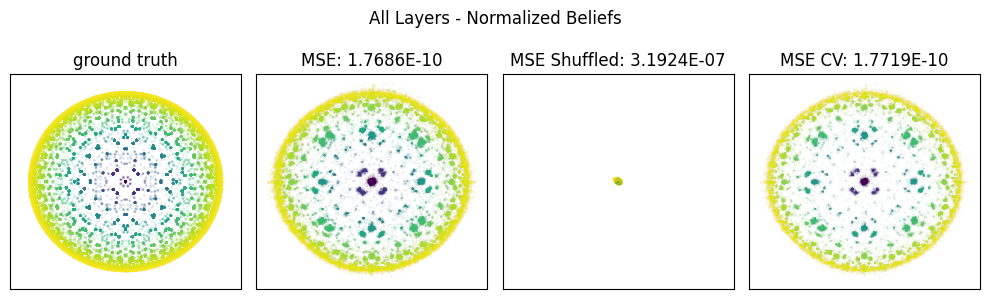

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


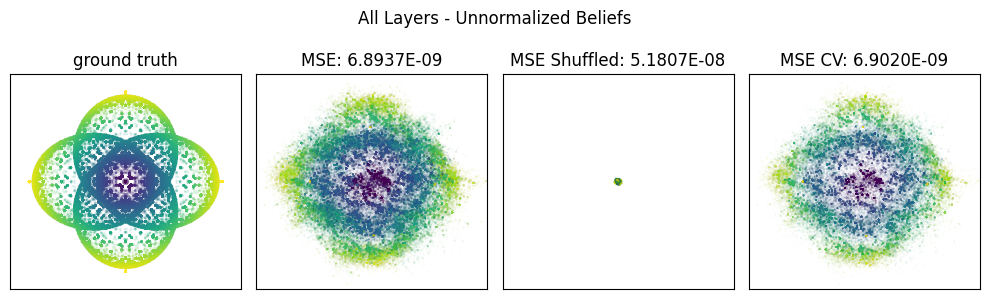

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


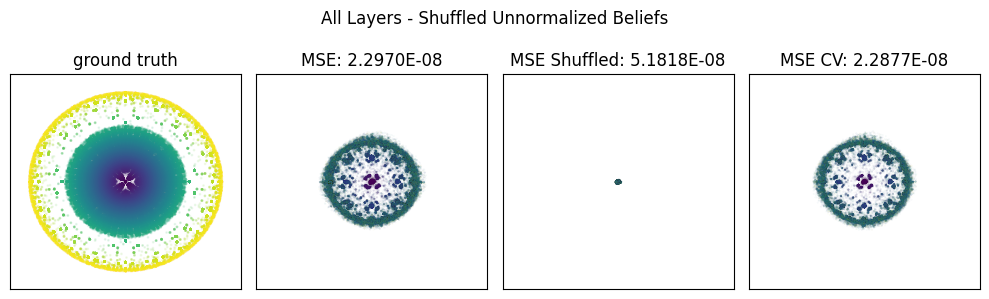

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


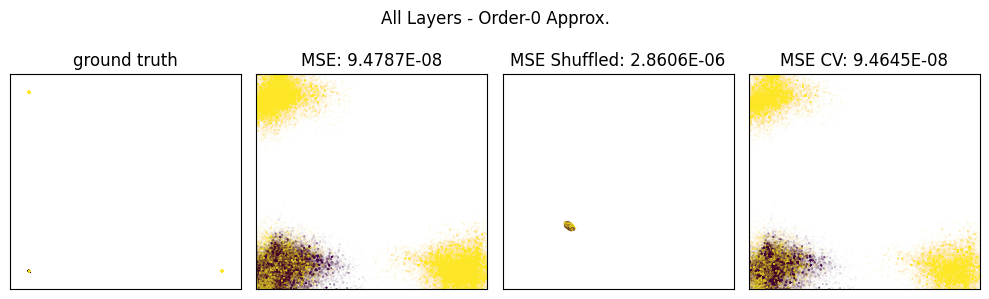

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


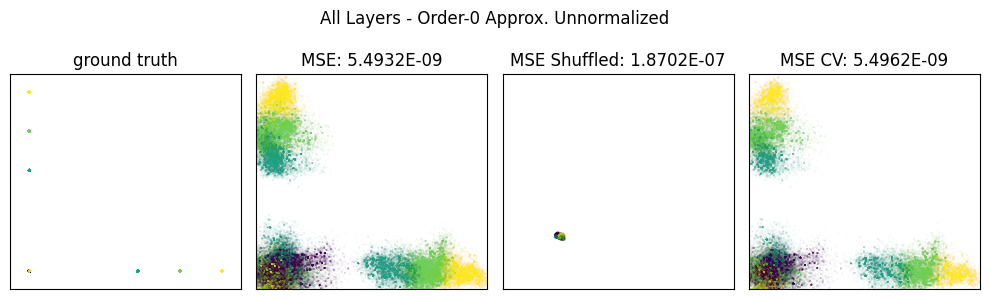

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


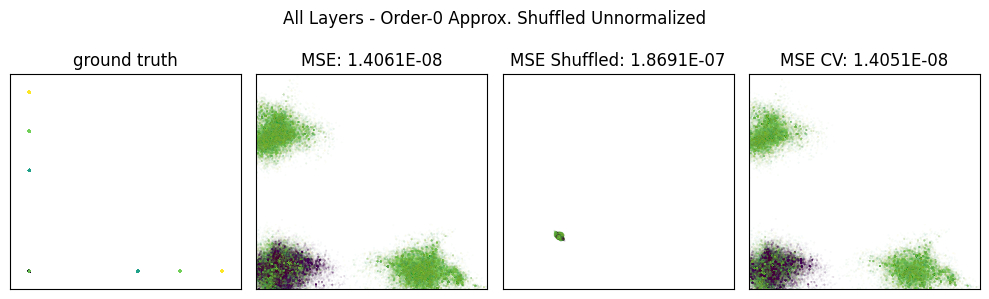

All layers concatenated shape: torch.Size([65536, 8, 64])
65536 8 64


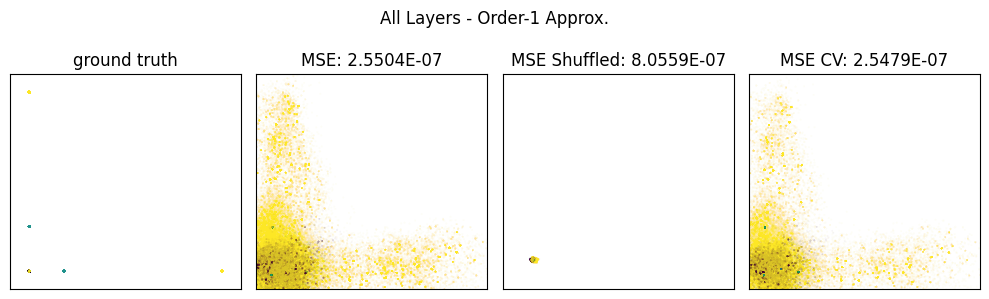

KeyboardInterrupt: 

In [4]:
loader = S3ModelLoader()
sweeps = {
    '20241121152808': 'RNN',
    '20241205175736': 'Transformer'
}

for sweep_id, sweep_type in sweeps.items():
        sweep_config = loader.load_sweep_config(sweep_id)
        runs = loader.list_runs_in_sweep(sweep_id)

        for run in tqdm(runs[1:3]):
            print(run)
            ckpts = loader.list_checkpoints(sweep_id, run)
            
            # Load initial model and prepare data
            model, config = loader.load_checkpoint(
                sweep_id=sweep_id,
                run_id=run,
                checkpoint_key=ckpts[-1],
                device='cpu'
            )

            nn_type = model_type(model)
            
            nn_data = prepare_msp_data(config, config['model_config'])
            (nn_inputs, nn_beliefs, nn_belief_indices, 
             nn_probs, nn_unnormalized_beliefs) = nn_data
            

            # Save the data in a dictionary format
            data_to_save = {
                'inputs': nn_inputs,
                'beliefs': nn_beliefs,
                'belief_indices': nn_belief_indices,
                'probs': nn_probs,
                'unnormalized_beliefs': nn_unnormalized_beliefs
            }
            # Create shuff
            # led version of unnormalized beliefs
            nn_shuffled_beliefs = shuffle_belief_norms(nn_unnormalized_beliefs)
            data_to_save['shuffled_beliefs'] = nn_shuffled_beliefs

            markov_data = markov_approx_msps(config, max_order=3)
            for order, mark_data in enumerate(markov_data):
                mark_inputs, mark_beliefs, mark_indices, mark_probs, mark_unnorm = mark_data
                mark_shuffled = shuffle_belief_norms(mark_unnorm)
                
                data_to_save.update({
                    f'markov_order_{order}_inputs': mark_inputs,
                    f'markov_order_{order}_beliefs': mark_beliefs,
                    f'markov_order_{order}_indices': mark_indices,
                    f'markov_order_{order}_probs': mark_probs,
                    f'markov_order_{order}_unnormalized': mark_unnorm,
                    f'markov_order_{order}_shuffled': mark_shuffled
                })

            print(f'the size of the data to save is {sys.getsizeof(data_to_save)/1024**2} MB')

            save_nn_data(loader, sweep_id, run, data_to_save)
            # Analyze last two checkpoints
            for ckpt in ckpts[-2:]:
                model, config = loader.load_checkpoint(
                    sweep_id=sweep_id,
                    run_id=run,
                    checkpoint_key=ckpt,
                    device='cpu'
                )
                sweep_type = get_sweep_type(run)

                # Analyze normalized beliefs
                analyze_model_checkpoint(
                    model, nn_inputs, nn_type, nn_beliefs, 
                    nn_belief_indices, nn_probs, sweep_type, run, title="Normalized Beliefs",
                    loader=loader,
                    checkpoint_key=ckpt,
                    sweep_id=sweep_id
                )

                # Analyze unnormalized beliefs
                analyze_model_checkpoint(
                    model, nn_inputs, nn_type, nn_unnormalized_beliefs, 
                    nn_belief_indices, nn_probs, sweep_type, run, title="Unnormalized Beliefs",
                    loader=loader,
                    checkpoint_key=ckpt,
                    sweep_id=sweep_id
                )


                # Analyze shuffled unnormalized beliefs
                analyze_model_checkpoint(
                    model, nn_inputs, nn_type, nn_shuffled_beliefs, 
                    nn_belief_indices, nn_probs, sweep_type, run, title="Shuffled Unnormalized Beliefs",
                    loader=loader,
                    checkpoint_key=ckpt,
                    sweep_id=sweep_id
                )


                # Analyze markov approximations
                for order, mark_data in enumerate(markov_data):
                    # unpack the data
                    nn_inputs, nn_beliefs, nn_belief_indices, nn_probs, nn_unnormalized_beliefs = mark_data
                     
                    # Create shuffled version of unnormalized beliefs
                    nn_shuffled_beliefs = shuffle_belief_norms(nn_unnormalized_beliefs)
                    
                    # Analyze normalized beliefs
                    analyze_model_checkpoint(
                        model, nn_inputs, nn_type, nn_beliefs, 
                        nn_belief_indices, nn_probs, sweep_type, run, title=f"Order-{order} Approx.",
                        loader=loader,
                        checkpoint_key=ckpt,
                        sweep_id=sweep_id
                    )
                     
                    # Analyze unnormalized beliefs
                    analyze_model_checkpoint(
                        model, nn_inputs, nn_type, nn_unnormalized_beliefs, 
                        nn_belief_indices, nn_probs, sweep_type, run, title=f"Order-{order} Approx. Unnormalized",
                        loader=loader,
                        checkpoint_key=ckpt,
                        sweep_id=sweep_id
                    )

                    # Analyze shuffled unnormalized beliefs
                    analyze_model_checkpoint(
                        model, nn_inputs, nn_type, nn_shuffled_beliefs, 
                        nn_belief_indices, nn_probs, sweep_type, run, title=f"Order-{order} Approx. Shuffled Unnormalized",
                        loader=loader,
                        checkpoint_key=ckpt,
                        sweep_id=sweep_id
                    )



In [5]:
type(nn_unnormalized_beliefs)


torch.Tensor